In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae_1D import *
import torch
import random
from torchvision.transforms import transforms as T, Lambda
from config import *
import sys
from notebook_utils import launch_train_advice
sys.path.append('../esa')
from esa.load_utils import *
from esa.conv_utils import *

import numpy as np
from omegaconf import OmegaConf

architecture = 'conv_ae1D'
os.environ['architecture'] = architecture
config_file = os.path.join(conf_path, architecture+'.yaml')
cfg = OmegaConf.load(config_file)
cfg.dataset.out_window = cfg.dataset.sequence_length

In [2]:
if os.path.exists(model_results+ '{}/'.format(architecture)):
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))
else:
    os.makedirs(model_results+ '{}/'.format(architecture))
    model_list = []

model num 0: conv_ae1D_sl_16_filter_n_110_kernel_size_7_24_03_2023_11:25:43.pth


In [3]:
launch_train_advice(cfg, model_list, config_file)

to train a model  switch train_model to True  in the next cell
to train a new model from scratch set train_model to True in the next cell

check the configuration file in /srv/penny/FIORIRE/time_series_anomaly_detection/configuration/conv_ae1D.yaml to set the hyperparameters of the model

actual dataset configuration is {'name': 'all_2016-2018_clean_std_4s.pkl', 'sequence_length': 16, 'columns': ['RW1_motcurr', 'RW2_motcurr', 'RW3_motcurr', 'RW4_motcurr', 'RW1_cmd_volt', 'RW2_cmd_volt', 'RW3_cmd_volt', 'RW4_cmd_volt', 'RW1_therm', 'RW2_therm', 'RW3_therm', 'RW4_therm', 'RW1_speed', 'RW2_speed', 'RW3_speed', 'RW4_speed'], 'train_val_split': 0.7, 'shuffle': 0, 'columns_subset': 0, 'dataset_subset': 1000000, 'batch_size': 500, 'sampling_rate': '4s', 'scaled': 1, 'target': None, 'forecast': 0, 'forecast_all': 0, 'predict': 0, 'out_window': 16}

actual architecture configuration is {'architecture': 'conv_ae1D', 'increasing': 0, 'flattened': 0, 'latent_dim': 100, 'stride': 1, 'pool': 1, 'ker

In [4]:
train_model = True

In [5]:
if train_model:
    !python ../main.py --config_name $architecture

now = 2023-03-31 15:11:28.590790
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE1D(
  (act): ELU(alpha=1.0)
  (encod

  8%|██▉                                  | 110/1400 [00:11<02:03, 10.41batch/s]Loss:
0.141074538230896

  9%|███▏                                 | 120/1400 [00:12<01:54, 11.18batch/s]Loss:
0.13673542439937592

  9%|███▍                                 | 130/1400 [00:13<01:57, 10.80batch/s]Loss:
0.11984005570411682

  0%|                                                | 0/200 [00:14<?, ?epoch/s]
Traceback (most recent call last):
  File "../main.py", line 91, in <module>
    main(args)
  File "../main.py", line 83, in main
    start_train(cfg, param_conf, train_iter, test_iter, device, checkpoint_path, model_name)
  File "/srv/penny/FIORIRE/time_series_anomaly_detection/utils/training.py", line 182, in start_train
    train_conv_ae1D(param_conf, train_iter, test_iter, model, criterion, optimizer, scheduler, device,
  File "/srv/penny/FIORIRE/time_series_anomaly_detection/models/conv_ae_1D.py", line 209, in train_conv_ae1D
    y_o = model(batch[0].to(device))
  File "/home/robertomorel

In [6]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
if len(model_list) > 0:
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))
    model_available = True
else:
    print('no model available')

model num 0: conv_ae1D_sl_16_filter_n_110_kernel_size_7_24_03_2023_11:25:43.pth


In [7]:
selected_model = 0
if model_available:
    print(model_list[selected_model])
    model_name = model_list[selected_model].split('.')[0]
else:
    print('no model available')

conv_ae1D_sl_16_filter_n_110_kernel_size_7_24_03_2023_11:25:43.pth


In [8]:
selected_model = 0
print(model_list[selected_model])
model_name = model_list[selected_model].split('.')[0]

conv_ae1D_sl_16_filter_n_110_kernel_size_7_24_03_2023_11:25:43.pth


In [9]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [11]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model]
                         , map_location=device)
params_conf = checkpoint['param_conf']

In [12]:
#cols = params_conf['columns']
cols = params_conf['columns']
params_conf['n_features'] = len(cols)
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

columns_subset = params_conf['columns_subset']
dataset_subset = params_conf['dataset_subset']

data_path = params_conf['data_path']
dataset = params_conf['name']
train_val_split = params_conf['train_val_split']

target = params_conf['target']
batch_size = params_conf['batch_size']
sequence_length = params_conf['sequence_length']
out_window = params_conf['out_window']
predict = params_conf['predict']
activation = params_conf['activation']
kernel_size = params_conf['kernel_size']
filter_num = params_conf['filter_num']
latent_dim = params_conf['latent_dim']
n_layers = params_conf['n_layers']

In [13]:
if 'flattened' in params_conf.keys():
    flattened = flattened=params_conf['flattened']
else:
    flattened=False
if 'increasing' in params_conf.keys():
    increasing = flattened=params_conf['increasing']
else:
    increasing=False
    
model = CONV_AE1D(in_channel=params_conf['n_features'],  length=params_conf['sequence_length']
                  , kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                  latent_dim = params_conf['latent_dim'],
                 n_layers=params_conf['n_layers'], activation = params_conf['activation']
                  , stride=params_conf['stride'], pool=params_conf['pool'],
                  flattened=flattened, increasing=increasing, bn = params_conf['bn']).to(device).float()

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE1D(
  (act): ELU(alpha=1.0)
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv1d(16, 110, kernel_size=(7,), stride=(1,), padding=(3,))
        (1): BatchNorm1d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
      (enc_lay_1): Sequential(
        (0): Conv1d(110, 55, kernel_size=(7,), stride=(1,), padding=(3,))
        (1): BatchNorm1d(55, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
    )
    (act): ELU(alpha=1.0)
  )
  (decoder): Decoder(
    (nn_dec): Sequential(
      (dec_lay_0): Sequential(
        (0): ConvTranspose1d(55, 110, kernel_size=(2,),

In [14]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

number of params 71435


In [15]:
transform = T.Compose([
    T.ToTensor(),
    Lambda(lambda x: x.permute((0, 2, 1))),
    Lambda(lambda x: x.squeeze())
])

dataset_name = os.path.join(data_path, "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, params_conf['scaled'],params_conf['columns_subset']
                  , params_conf['dataset_subset'], params_conf['columns'], 
                 params_conf['train_val_split'], params_conf['sequence_length']
                  ,params_conf['sequence_length'],  predict=False,
                 batch_size=4, transform=transform )

In [16]:
compute_mse_val_loss = False

In [17]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

In [18]:
num_batch = 5

x, shift = unrolling_batches_conv(num_batch=num_batch, test_iter=test_iter, arch='conv_ae1D',
                         sequence_length=sequence_length, cols=cols, shift = None)
    
print('time horizon', num_batch*params_conf['sequence_length'])

time horizon 80


In [19]:
yo = model(x.to(device))

In [20]:
seq_len = sequence_length
par_nums = count_parameters(model)

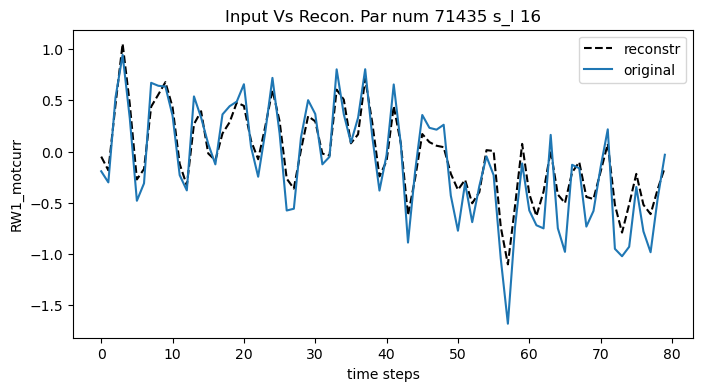

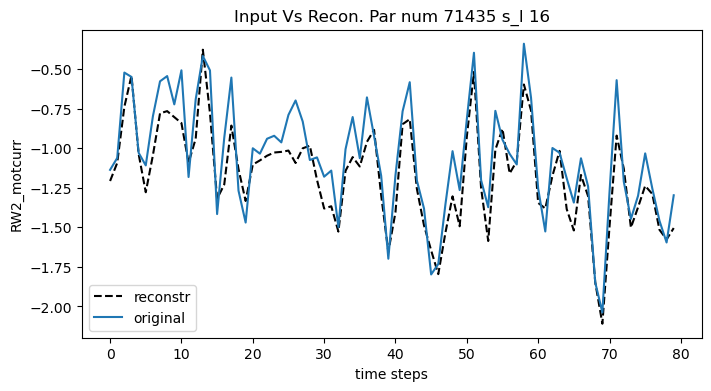

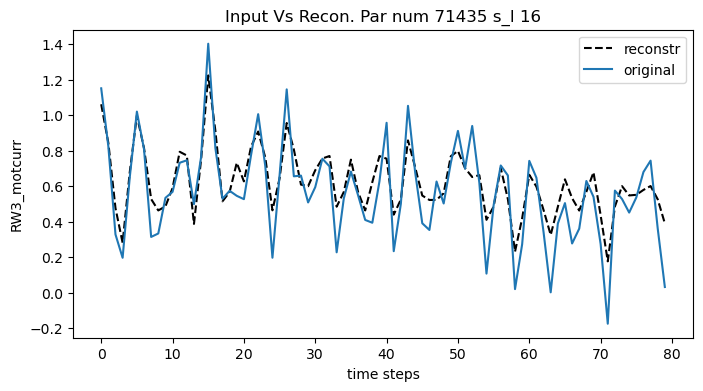

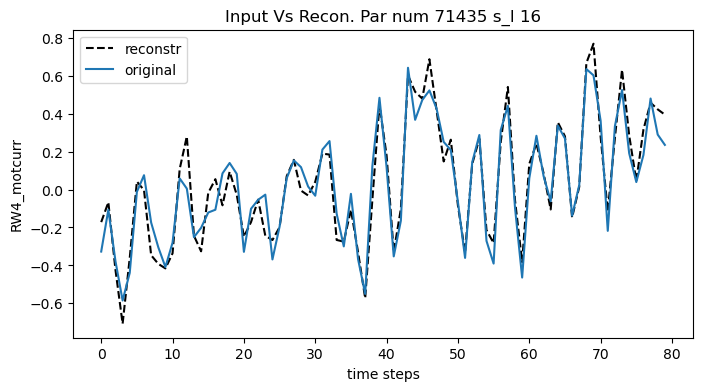

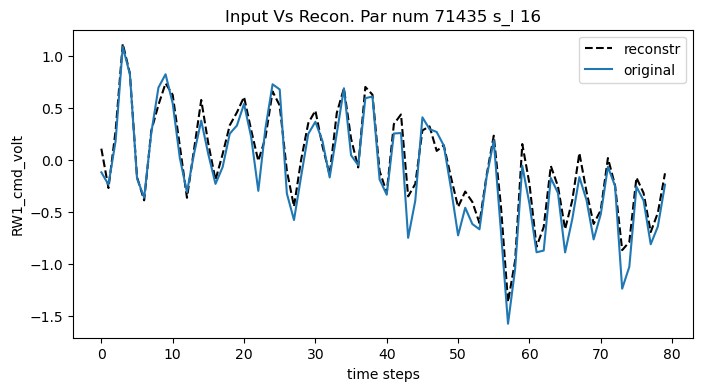

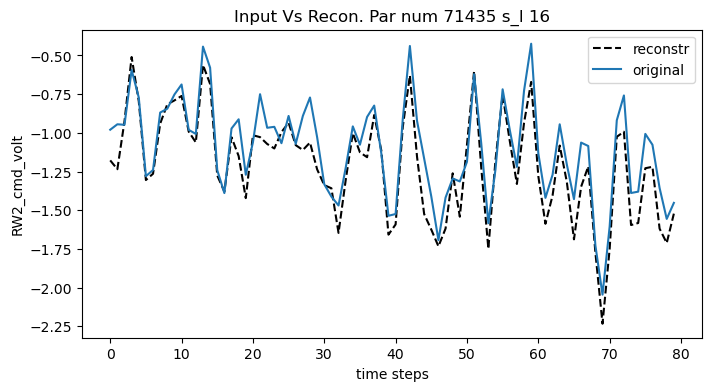

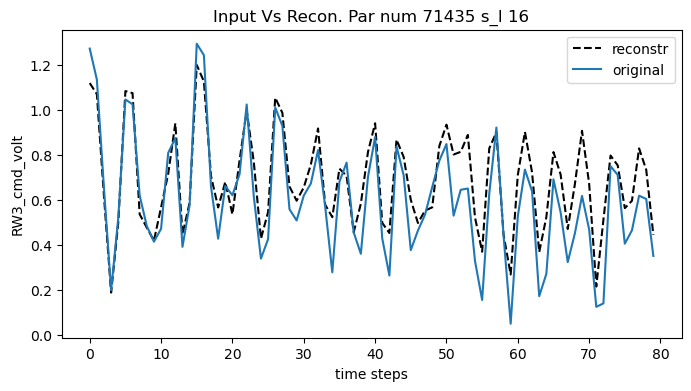

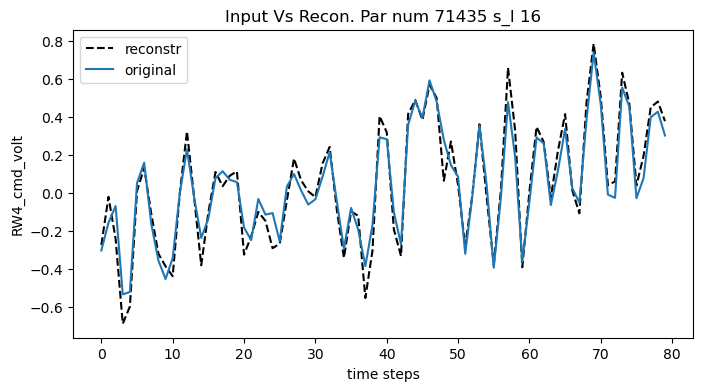

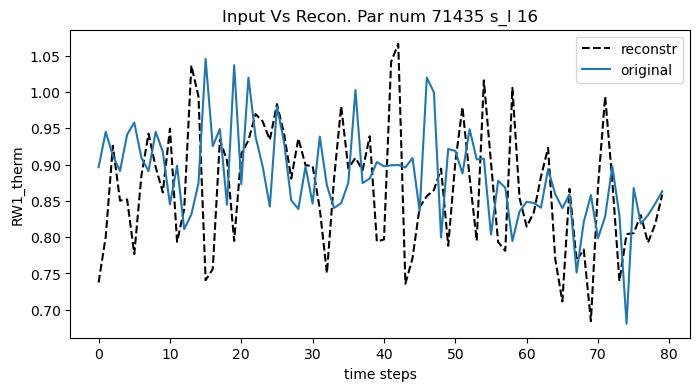

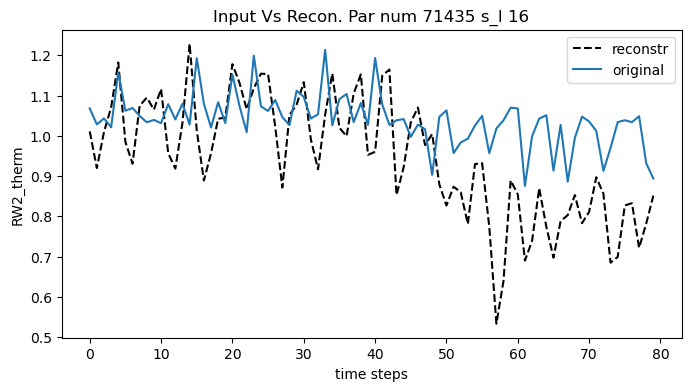

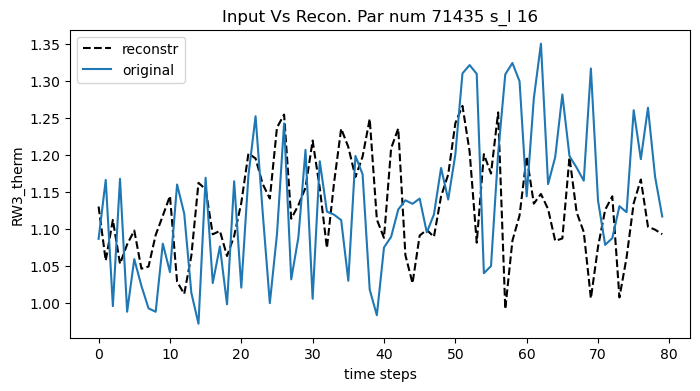

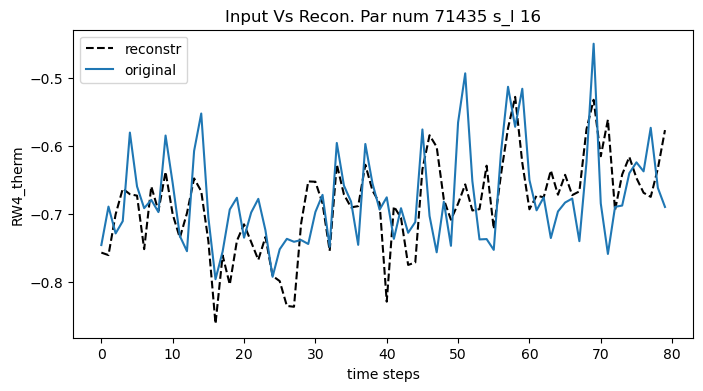

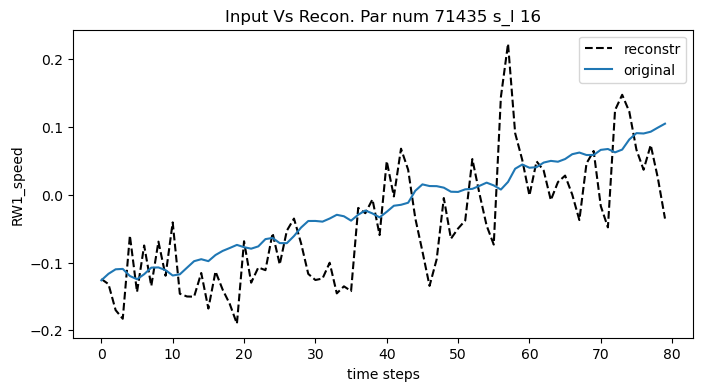

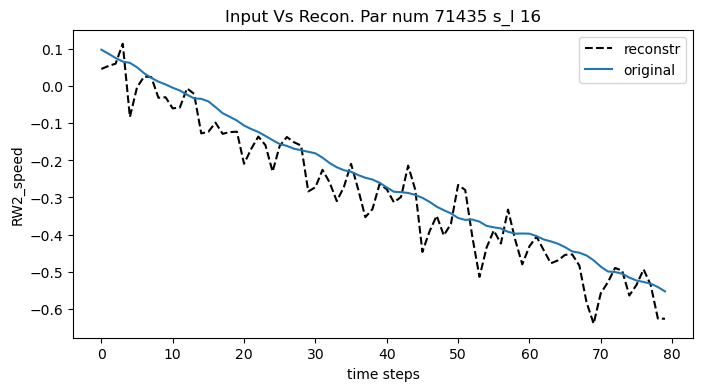

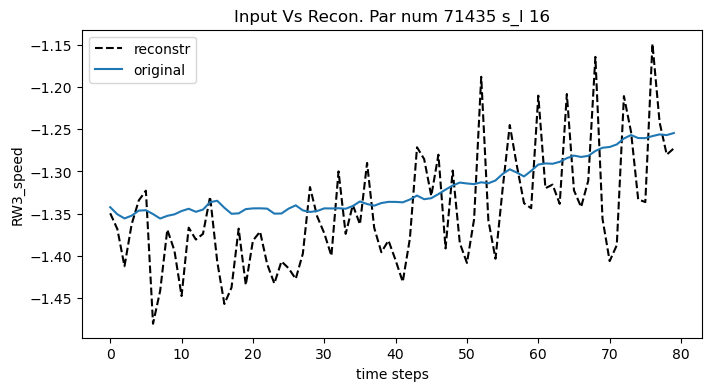

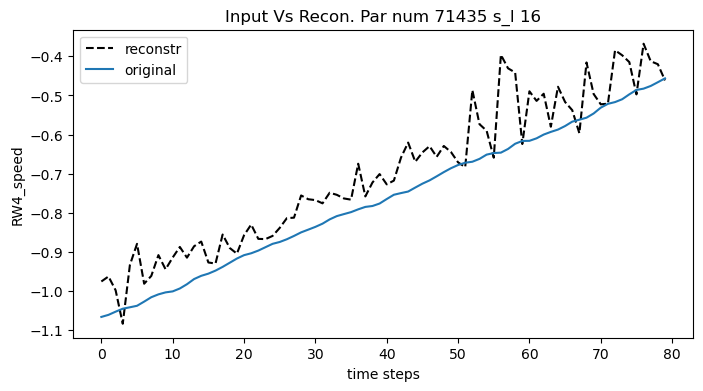

In [21]:
x_plot = x.squeeze().to(device)
show_results(x_plot , yo, cols, model_name, params_conf
     , par_nums, shift, num_batch,arch=architecture,save=False)